<a href="https://colab.research.google.com/github/MuhammadIrzam447/MultiModel/blob/master/Valid_48.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !gdown https://drive.google.com/uc?id=1IcjGsXSKVtTaZ79t9pBct4tRthOMjiGY

In [ ]:
# !gdown https://drive.google.com/uc?id=1ZXg6NUXKybfjV7e0O58TI3FogTz0pL5d

In [ ]:
# !unzip "/content/joint-train+test_unseen.zip"

In [ ]:
!pip install transformers
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor, AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


# New Section

In [3]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

# Define transformations for the input images
transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std)
])


In [4]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, val_transform):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir)
        self.classes = self.dataset.classes
        self.val_transform = val_transform

        self.selected_indices = []
        for class_idx in range(len(self.classes)):
            indices = [idx for idx, (_, label) in enumerate(self.dataset.samples) if label == class_idx]
            indices_3 = [idx for idx in indices if self.dataset.samples[idx][0].endswith("_3.png")]    # _3.png are the encoded_text images
            indices_4 = [idx for idx in indices if self.dataset.samples[idx][0].endswith("_4.png")]    # _4.png are the actual images

            self.selected_indices.extend(indices_4)
            # self.selected_indices.extend(indices_3)
        print("Selected Indices:", len(self.selected_indices))
        # for idx in self.selected_indices:
          # print(self.dataset.samples[idx][0])

    def __getitem__(self, index):
        # print("Entered get_item")
        img, label = self.dataset[self.selected_indices[index]]
        filename = self.dataset.samples[self.selected_indices[index]][0]
        image_3 = None
        image_4 = None
        if filename.endswith("_4.png"):
                image_4 = img
                image_4_path = filename
                # print("image_4_path: ", str(filename))
                image_3_path = filename.replace('_4.png', '_3.png')
                # print("image_3_path: ", str(image_3_path))
                image_3 = self._load_image(image_3_path)
        else:
                image_3 = img
                image_3_path = filename
                # print("image_3_path: ", str(filename))
                image_4_path = filename.replace('_3.png', '_4.png')
                # print("image_4_path: ", str(image_4_path))
                image_4 = self._load_image(image_4_path)

        # print("Exit get_item")
        return image_3, image_4, label, image_3_path, image_4_path

    def _load_image(self, path):
        image = Image.open(path)
        return image

    def __len__(self):
        return len(self.selected_indices)

In [5]:
valPath = "/content/mulitmodal/test"
val_dataset = ValidationDataset(valPath,transform)

Selected Indices: 2000


In [6]:
label2id = {class_name: idx for class_name, idx in val_dataset.dataset.class_to_idx.items()}
id2label = {idx: class_name for class_name, idx in val_dataset.dataset.class_to_idx.items()}

In [7]:
label2id

{'0': 0, '1': 1}

In [8]:
id2label

{0: '0', 1: '1'}

In [9]:
def custom_collate(batch):
    to_tensor = transforms.ToTensor()
    # Define transformations for the input images
    val_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std)
    ])

    images_3 = [val_transform(item[0]) for item in batch]
    images_4 = [val_transform(item[1]) for item in batch]
    labels = [torch.tensor(item[2]) for item in batch]

    images_3 = torch.stack(images_3)
    images_4 = torch.stack(images_4)

    # Print the filenames in each list
    # print("Filenames in images_3 list:")
    # for item in batch:
    #     if item[0] is not None:
    #         print(item[3])

    # print("Filenames in images_4 list:")
    # for item in batch:
    #     if item[1] is not None:
    #         print(item[4])

    return images_3, images_4, labels

In [10]:
batch_size = 16
num_workers = 1

validation_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

# New Section

In [11]:
num_classes = len(val_dataset.classes)
print(num_classes)

2


In [12]:
save_dir = '/content/'
load_path = os.path.join(save_dir, '11_model.pth')

vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True, num_labels=num_classes)
vit.load_state_dict(torch.load(load_path))

vit.to(device)
print(vit)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

# New Section

In [13]:
print("Number of samples:", len(val_dataset))
print("Number of classes:", len(val_dataset.classes))

Number of samples: 2000
Number of classes: 2


In [14]:
num_batches = len(validation_data_loader)
print("Number of batches:", num_batches)

Number of batches: 125


In [15]:
num_batches = len(validation_data_loader)
num_batches_with_logits_3 = int(num_batches * 0.3)  # __% of batches that you want to include (30 for now)
print("Total Batches: ", num_batches)
print("Missing Modaility Batches: ", num_batches_with_logits_3)

Total Batches:  125
Missing Modaility Batches:  37


In [16]:
print("""
1. 100% Text Missing (Image-only Validation)
2. 100% Image Missing (Text-only Validation)
3. Missing Modality Check""")
method = str(input("Choose method: "))


1. 100% Text Missing (Image-only Validation)
2. 100% Image Missing (Text-only Validation)
3. Missing Modality Check
Choose method: 3


In [17]:
vit.eval()

# Initialize lists to store the average probabilities and true labels
predicted_labels = []
true_labels = []


batch_idx = 0
for images_3, images_4, labels in validation_data_loader:

    if method == "1":
      print("M1")
      images_4 = images_4.to(device)
      logits_4 = vit(images_4).logits
      logits_3 = torch.zeros_like(logits_4)

    elif method == "2":
      print("M2")
      images_3 = images_3.to(device)
      logits_3 = vit(images_3).logits
      logits_4 = torch.zeros_like(logits_3)

    elif method == "3":
      print("M3")
      images_4 = images_4.to(device)
      logits_4 = vit(images_4).logits
      if batch_idx < num_batches_with_logits_3:
          images_3 = images_3.to(device)
          logits_3 = vit(images_3).logits
      else:
          logits_3 = torch.zeros_like(logits_4)
    else:
      print("Invalid Choice!")
      break

    probabilities_3 = torch.softmax(logits_3, dim=1)
    probabilities_4 = torch.softmax(logits_4, dim=1)

    avg_probabilities_batch = (probabilities_3 + probabilities_4) / 2

    predicted_labels.extend(avg_probabilities_batch.cpu().tolist())
    true_labels.extend(labels)
    batch_idx += 1

print(batch_idx)

M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
M3
125


In [18]:
predicted_classes = torch.argmax(torch.tensor(predicted_labels), dim=1)
actual_labels = torch.tensor(true_labels)

In [19]:
accuracy = accuracy_score(actual_labels, predicted_classes)
precision = precision_score(actual_labels, predicted_classes, average='weighted')
recall = recall_score(actual_labels, predicted_classes, average='weighted')
f1 = f1_score(actual_labels, predicted_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7355
Precision: 0.7366952255616173
Recall: 0.7355
F1-score: 0.717269932435539


In [20]:
print(classification_report(actual_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.73      0.91      0.81      1250
           1       0.74      0.45      0.56       750

    accuracy                           0.74      2000
   macro avg       0.74      0.68      0.69      2000
weighted avg       0.74      0.74      0.72      2000



In [21]:
auroc = roc_auc_score(actual_labels, predicted_classes)
print("AUROC:", auroc)

AUROC: 0.6788


In [22]:
cm = confusion_matrix(actual_labels, predicted_classes)
print(cm)

[[1132  118]
 [ 411  339]]


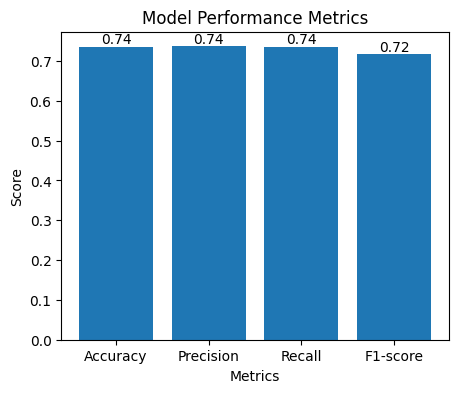

In [23]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(x, values)

# labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# scores on top of each bar
for i, bar in enumerate(bars):
    score = values[i]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')

plt.show()

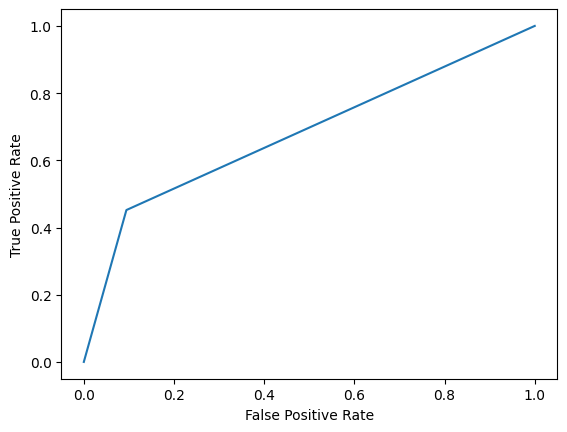

In [24]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(actual_labels,  predicted_classes)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()